# Dog Breed Classification

#### **Objective**
The primary goal of this project is to develop a model that can classify images of dogs into one of 133 distinct dog breeds. 

#### **Dataset**
The dataset consists of dog images organized into three main sets:
- **Training Set**: Contains 6680 images across 133 dog breeds.
- **Validation Set**: Used to evaluate the model during training.
- **Test Set**: Used to assess the model's final performance after training.

Each breed has its own folder within the `train`, `valid`, and `test` directories, which are loaded into the model as labeled data.

#### **Approach**
1. **Custom CNN Model**:
   - A CNN was built from scratch to handle the classification task. Specifically, we began with a CNN built from scratch to classify dog breeds. While this model learned some features, it struggled with overfitting and achieved moderate accuracy (around 17% on the test set). This indicates that the custom CNN might not be complex or large enough to capture the intricacies of 133 different dog breeds.
   
   - The architecture includes several convolutional layers, max-pooling layers, batch normalization, and fully connected layers, along with dropout and L2 regularization to prevent overfitting.
   - The network was trained with the RMSprop optimizer and categorical cross-entropy loss, suitable for multi-class classification problems.

2. **Transfer Learning**:
   - To improve the accuracy, transfer learning with pre-trained models like ResNet50 or VGG16 was employed.  This approach allows leveraging pre-trained convolutional layers for feature extraction, while only training the fully connected layers specific to the dog breed classification task. 
   - Specifically, recognizing the limitations of the CNN, we transitioned to using a pre-trained VGG16 model. VGG16, which is pre-trained on ImageNet, has already learned powerful feature extraction methods that can generalize well to various tasks, including dog breed classification. 
    - We used VGG16 to extract bottleneck features—the output of the last convolutional layer of the VGG16 model. These features encapsulate high-level representations of the images, such as shapes and textures, which are useful for classification. 
    - Therefore, instead of training the entire VGG16 network, we added a custom classifier (e.g., fully connected layers) on top of these bottleneck features and trained only those layers for the dog breed classification task.
  

3. **Checkpointing**:
   - Model weights are saved during training using the `ModelCheckpoint` callback, ensuring that the best model based on validation accuracy is preserved.

4. **Training Process**:
   - The model is trained over multiple epochs (15 in this case), with batch size of 20.
   - The training output shows progress across 334 steps per epoch, where each step processes a batch of 20 images.

5. **Evaluation**:
   - After training, the model is evaluated on the test set to determine its performance.
   - Accuracy and validation loss are used as key metrics for assessing model performance and tuning.

#### **Challenges**
- **Overfitting**: One of the primary challenges is overfitting, given the relatively small dataset for a deep learning model. Regularization techniques like dropout, L2 regularization, and data augmentation can help mitigate this.
- **Data Augmentation**: Data augmentation could further improve the model's generalization by artificially increasing the diversity of the training data through transformations such as rotations, flips, and zooming.

#### **Conclusion**
This project focuses on applying deep learning to classify dog breeds from images. 

In [1]:
import os
import zipfile
import requests
from sklearn.datasets import load_files       
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
from keras.applications.resnet50 import ResNet50

from keras.preprocessing import image                  
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True    

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,ZeroPadding2D,Activation
from keras.layers import Dropout, Flatten, Dense,BatchNormalization
from keras.models import Sequential,Model,model_from_json
from keras import optimizers
from keras.callbacks import ModelCheckpoint  
from keras import layers
from keras import regularizers



In [2]:

# Download the dog image dataset
url = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'
dataset_path = 'dogImages.zip'

if not os.path.exists(dataset_path):
    response = requests.get(url)
    with open(dataset_path, 'wb') as f:
        f.write(response.content)

# Unzip the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('dogImages')


In [3]:

# Check if 'dogImages/dogImages' directory exists
if os.path.exists('dogImages/dogImages'):
    print("The 'dogImages/dogImages' directory exists!")
    
    # List all files and directories in 'dogImages/dogImages'
    print("Contents of 'dogImages/dogImages':")
    print(os.listdir('dogImages/dogImages'))
    
    # Set correct directory paths for train, valid, and test
    train_dir = os.path.join('dogImages', 'dogImages', 'train')
    valid_dir = os.path.join('dogImages', 'dogImages', 'valid')
    test_dir = os.path.join('dogImages', 'dogImages', 'test')

    if os.path.exists(train_dir):
        print(f"'train' directory exists in 'dogImages/dogImages'. Contents of 'train':")
        print(os.listdir(train_dir))
    else:
        print("'train' directory does not exist in 'dogImages/dogImages'.")
    
    if os.path.exists(valid_dir):
        print(f"'valid' directory exists in 'dogImages/dogImages'. Contents of 'valid':")
        print(os.listdir(valid_dir))
    else:
        print("'valid' directory does not exist in 'dogImages/dogImages'.")
    
    if os.path.exists(test_dir):
        print(f"'test' directory exists in 'dogImages/dogImages'. Contents of 'test':")
        print(os.listdir(test_dir))
    else:
        print("'test' directory does not exist in 'dogImages/dogImages'.")
else:
    print("The 'dogImages/dogImages' directory does not exist.")


The 'dogImages/dogImages' directory exists!
Contents of 'dogImages/dogImages':
['valid', 'test', 'train']
'train' directory exists in 'dogImages/dogImages'. Contents of 'train':
['122.Pointer', '069.French_bulldog', '124.Poodle', '112.Nova_scotia_duck_tolling_retriever', '043.Canaan_dog', '024.Bichon_frise', '036.Briard', '086.Irish_setter', '078.Great_dane', '061.English_cocker_spaniel', '075.Glen_of_imaal_terrier', '089.Irish_wolfhound', '054.Collie', '109.Norwegian_elkhound', '077.Gordon_setter', '035.Boykin_spaniel', '007.American_foxhound', '084.Icelandic_sheepdog', '058.Dandie_dinmont_terrier', '076.Golden_retriever', '125.Portuguese_water_dog', '070.German_pinscher', '008.American_staffordshire_terrier', '123.Pomeranian', '026.Black_russian_terrier', '082.Havanese', '087.Irish_terrier', '002.Afghan_hound', '027.Bloodhound', '133.Yorkshire_terrier', '049.Chinese_crested', '074.Giant_schnauzer', '132.Xoloitzcuintli', '101.Maltese', '019.Bedlington_terrier', '034.Boxer', '003.Aired

### Import Libraries and Check Image Data
Next, we import the required libraries and set up the data generators to load and check the data.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize the pixel values to [0, 1]
    shear_range=0.2,         # Apply random shear transformations
    zoom_range=0.2,          # Apply random zoom transformations
    horizontal_flip=True)    # Randomly flip the images horizontally

validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation

# Adjusted the paths to the correct nested directory structure
train_generator = train_datagen.flow_from_directory(
    'dogImages/dogImages/train',  # Adjusted path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'dogImages/dogImages/valid',  # Adjusted path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_files
from glob import glob
from keras.preprocessing import image
from tqdm import tqdm
# Function to load datasets from directories
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)  # Assuming 133 dog breeds
    return dog_files, dog_targets


# Load the datasets using the correct paths
train_files, train_targets = load_dataset('dogImages/dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/dogImages/valid')
test_files, test_targets = load_dataset('dogImages/dogImages/test')

# Extract the names of the dog breeds
dog_names = [item.split('/')[-2] for item in sorted(glob("dogImages/dogImages/train/*/"))]
print(f'There are {len(dog_names)} total dog categories.')
print(f'There are {len(np.hstack([train_files, valid_files, test_files]))} total dog images.')
print(f'There are {len(train_files)} training dog images.')
print(f'There are {len(valid_files)} validation dog images.')
print(f'There are {len(test_files)} test dog images.')


There are 133 total dog categories.
There are 8351 total dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


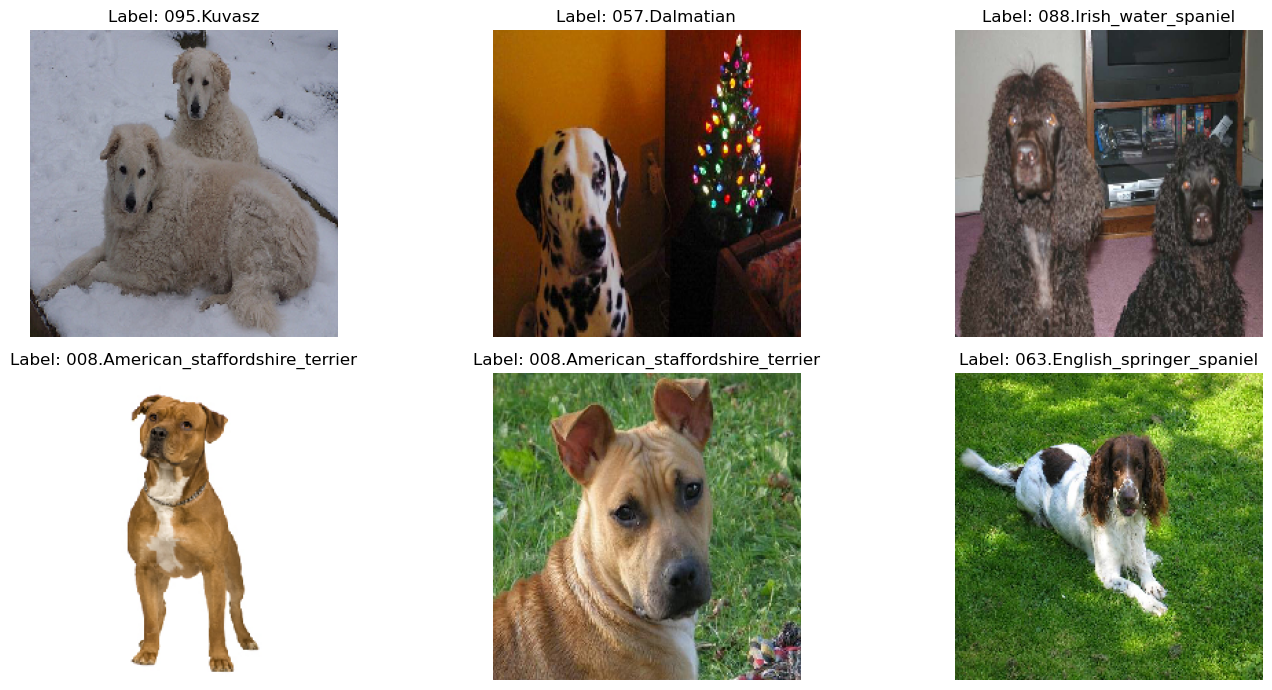

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing import image

# Display random sample images from the dataset with labels
def plot_sample_images(images, labels, dog_names, num_images=6):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        img = image.load_img(images[i], target_size=(224, 224))
        plt.imshow(img)
        plt.title(f"Label: {dog_names[np.argmax(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example Usage (Replace train_files and train_targets with your dataset variables)
plot_sample_images(train_files[:6], train_targets[:6], dog_names)




In [7]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))


In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [00:03<00:00, 267.75it/s]



### **1. Architecture Overview**
The CNN architecture consists of the following key components:
- **Convolutional Layers**: Used for feature extraction by applying filters to the input images.
- **Max Pooling Layers**: Reduces the spatial dimensions of the feature maps, which lowers computational complexity and makes the model more efficient.
- **Batch Normalization**: Normalizes the inputs to the next layer, stabilizing the learning process and improving training speed.
- **Activation Function (ReLU)**: Introduces non-linearity to the model, allowing it to learn more complex patterns.
- **Global Average Pooling**: Replaces the flattening operation by averaging out the feature maps, reducing overfitting and the number of parameters.
- **Dropout**: Randomly drops a percentage of the neurons during training to prevent overfitting.
- **Fully Connected Layers**: The final classification is performed using dense layers with a softmax activation for multi-class classification.

### **2. Regularization Techniques**
- **L2 Regularization**: This technique adds a penalty term to the loss function proportional to the squared magnitude of the weights. It helps in preventing overfitting by constraining the weight values.
- **Dropout**: Dropout randomly sets some neurons to zero during training, which helps the model generalize better by preventing it from becoming too dependent on any specific neurons.

### **3. Training Strategy**
The model is compiled using the **RMSprop optimizer** with a learning rate of `1e-4`, which is effective for models with complex architectures. The loss function is **categorical crossentropy**, commonly used for multi-class classification problems. The metric chosen for performance evaluation is **accuracy**.

To avoid overfitting and ensure that the best-performing model is saved, the **ModelCheckpoint callback** is used. It saves the model weights whenever there is an improvement in validation accuracy, allowing us to retrieve the best model after training.

### **4. Detailed Layer-by-Layer Explanation**
1. **Convolutional Layers**: The model starts with four convolutional layers, where each layer applies a set of filters to the input image to extract features such as edges, textures, and shapes. The number of filters increases as we go deeper into the network (from 16 to 128).
2. **Pooling Layers**: Each convolutional layer is followed by a max-pooling layer, which reduces the size of the feature maps by selecting the maximum value in a 3x3 window. This downsampling helps the model focus on the most relevant features.
3. **Batch Normalization**: After the convolution layers, batch normalization is applied, which normalizes the activations of the previous layer, leading to faster convergence and more stable training.
4. **Activation Functions**: ReLU is used as the activation function throughout the network, introducing non-linearity to the model.
5. **Dropout**: Dropout layers with probabilities of `0.3` and `0.4` are used before the fully connected layers to improve generalization by preventing overfitting.
6. **Global Average Pooling**: Instead of flattening the feature maps, the global average pooling layer averages each feature map to a single number. This reduces the number of parameters and helps avoid overfitting.
7. **Fully Connected Layers**: The final dense layers are used to perform classification, and the last dense layer has `softmax` activation, which outputs a probability distribution over all dog breeds.

### **5. Checkpointing and Model Saving**
The `ModelCheckpoint` callback is responsible for saving the model weights to a file named `weights.best.from_scratch.h5`. This file contains the best weights of the model based on validation accuracy during training. If training is interrupted, the best version of the model can be retrieved and used for testing or deployment.

### **Conclusion**
The model was trained over several epochs using the CNN architecture described above. By employing regularization techniques such as dropout and L2 regularization, along with callbacks for saving the best model, the CNN should generalize well to unseen data, ensuring good performance on the dog breed classification task. After training, the best weights are stored in the `weights.best.from_scratch.h5` file, which can later be loaded to use the best version of the model.


In [11]:
reg=10**(np.random.uniform(-4,0))
model = Sequential()
### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(128, (3, 3)))
#Batch Normalization normalizes each batch by both mean and variance reference.
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=3))


model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D())#Flatten

model.add(Dense(512,activation='relu',kernel_regularizer=regularizers.l2(reg)))
model.add(Dropout(0.4))
model.add(Dense(len(dog_names), activation='softmax'))


model.summary()

/Users/yuyao/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 133)            │        68,229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,229 (907.14 KB)

 Trainable params: 231,973 (906.14 KB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Note:
The model is processing **334 batches** per epoch, not the total number of images in the dataset (6680). Since you have 6680 images in the training dataset, the number of steps per epoch is calculated as:


- **Total training images**: 6680
- **Batch size**: 20
- **Steps per epoch**: \( 6680 / 20 = 334 \)

    
    

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Number of epochs
epochs = 15

# Checkpoint callback to save the best model during training
checkpointer = ModelCheckpoint(filepath='./weights.best.from_scratch.keras',  # Changed to .keras
                               verbose=1, save_best_only=True)

# Training the model with the checkpoint
history = model.fit(train_tensors, train_targets, 
                    validation_data=(valid_tensors, valid_targets),
                    epochs=epochs, batch_size=20, 
                    callbacks=[checkpointer], verbose=1)





# Load the best weights after training into the 'model' object
model.load_weights('./weights.best.from_scratch.keras')

Epoch 1/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0134 - loss: 5.1331
Epoch 1: val_loss improved from inf to 4.90542, saving model to ./weights.best.from_scratch.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.0134 - loss: 5.1327 - val_accuracy: 0.0299 - val_loss: 4.9054
Epoch 2/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0315 - loss: 4.6549
Epoch 2: val_loss improved from 4.90542 to 4.78016, saving model to ./weights.best.from_scratch.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.0315 - loss: 4.6547 - val_accuracy: 0.0216 - val_loss: 4.7802
Epoch 3/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0516 - loss: 4.3658
Epoch 3: val_loss improved from 4.78016 to 4.31941, saving model to ./weights.best.from_scratch.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.0516 - loss: 4.3657 - val_accuracy: 0.0515 - val_loss: 4.3194
Epoch 4/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0625 - loss: 



### **Summary of Key Results**

- **Training Accuracy**: The model's accuracy improved from 1.48% at epoch 1 to 24.68% at epoch 15, indicating some learning progress.
- **Validation Accuracy**: Validation accuracy started at 2.63% and reached 17.84% by the end of training, showing modest improvement but still relatively low for a 133-class problem.
- **Overfitting**: The gap between training and validation accuracy suggests overfitting. The training accuracy improved significantly, but the validation accuracy lagged and fluctuated in later epochs, indicating the model struggled to generalize.
- **Validation Loss**: The validation loss decreased initially but fluctuated in later epochs, reinforcing the signs of overfitting.



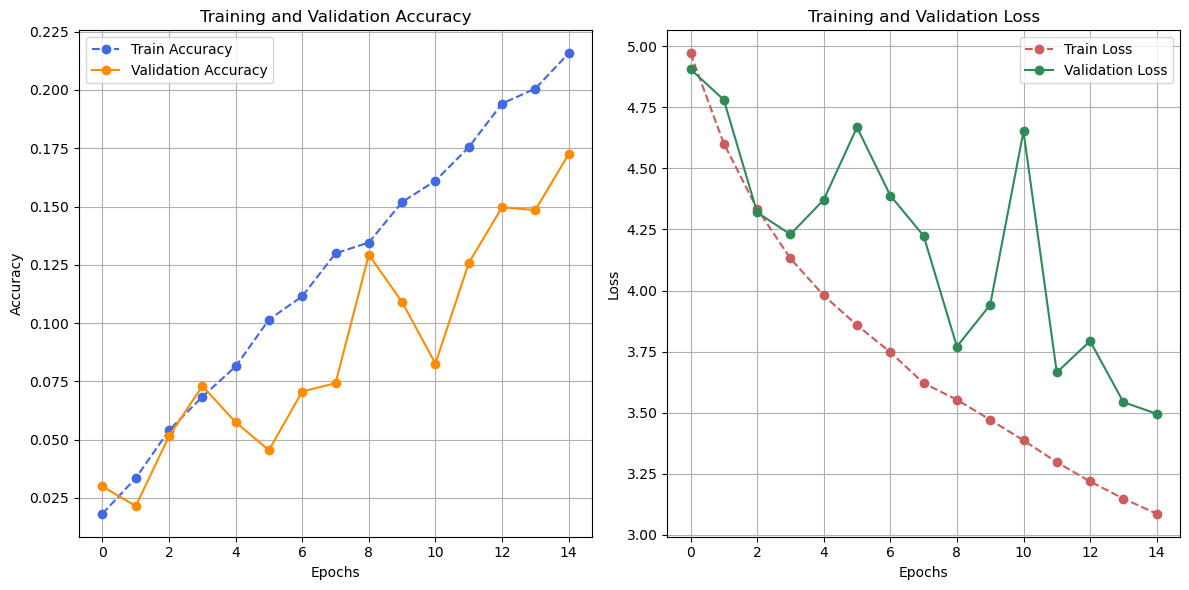

In [14]:

# Plotting the accuracy and loss curves
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color='royalblue', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='darkorange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='indianred', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='seagreen')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Analysis of Training and Validation Results**

#### **Accuracy Plot (Left)**
- **Training Accuracy**: The training accuracy shows a gradual upward trend over the 15 epochs, starting from nearly 0.02 (2%) and rising to around 0.22 (22%). This suggests that the model is learning from the training data but at a slower pace compared to more optimized models. The improvement is steady, indicating that the model is making progress in adjusting its parameters to minimize errors on the training set.

- **Validation Accuracy**: The validation accuracy shows more fluctuations compared to the training accuracy. Although it follows a general upward trend, there are noticeable drops in accuracy at various points during the training process. The final validation accuracy reaches around 0.18 (18%), which indicates that while the model does generalize to unseen data, its performance is less stable and consistent compared to its training performance.

#### **Loss Plot (Right)**
- **Training Loss**: The training loss decreases steadily throughout the training epochs, starting from approximately 5.0 and declining to about 3.0 by the end. This consistent decrease in training loss reflects the model's ability to improve its predictions on the training data by gradually minimizing errors.

- **Validation Loss**: The validation loss, much like the validation accuracy, exhibits considerable fluctuation. While there is a general downward trend, several epochs show a significant increase in loss, indicating that the model is struggling to generalize well to the validation data. The final validation loss is still higher than the training loss, which could be a sign of **overfitting**.

### **Overall Observations**
- **Generalization Issues**: The fluctuating validation accuracy and loss suggest that the model has overfitting issues. It is performing well on the training data but struggles to generalize to unseen data, as reflected in the erratic validation performance. This could be a result of the model memorizing specific patterns in the training data that are not representative of new data.
  
- **Training Performance**: The model shows a consistent improvement in training accuracy and a reduction in training loss, indicating successful learning from the training set. However, the model's inconsistent performance on the validation set implies that further adjustments—such as adding more regularization techniques, fine-tuning hyperparameters, or increasing the dataset size—are necessary to improve its ability to generalize to new data.

In [15]:
import tensorflow as tf
# Disable TensorFlow progress bar
tf.get_logger().setLevel('ERROR')

# Get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0), verbose=0)) for tensor in test_tensors]

# Report test accuracy
test_accuracy = 100 * np.sum(np.array(dog_breed_predictions) == np.argmax(test_targets, axis=1)) / len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 16.8660%



The result of **Test accuracy: 16.8660%** indicates that the model correctly classified the dog breed for approximately 16.9% of the images in the test set. However, it is still far from performing at a satisfactory level. 




### **Exploring Transfer Learning with Pre-trained Models (ResNet50 or VGG16)**

#### **Overview**
To improve the model's performance in dog breed classification, we will explore transfer learning with pre-trained models like **ResNet50** and **VGG16**. These models are pre-trained on the **ImageNet** dataset, which contains millions of images across thousands of categories. Transfer learning allows us to leverage these models' learned features, significantly improving accuracy and generalization while reducing training time.

#### **Method**
1. **Pre-trained Model**: Load a pre-trained model (ResNet50 or VGG16) without the top classification layers.
2. **Freeze Layers**: Freeze the convolutional layers, keeping their weights intact to use them as feature extractors.
3. **Add Custom Layers**: Add fully connected layers specific to the dog breed classification task (133 classes).
4. **Fine-tuning**: Train only the custom layers first, and optionally fine-tune the entire network later.

By leveraging these pre-trained models, we aim to overcome the limitations of training from scratch, improving accuracy and reducing overfitting.



## Generate Bottleneck Features 

Leverage Pre-trained Knowledge: VGG16 is pre-trained on a large dataset like ImageNet, which includes millions of images across thousands of categories. The model has already learned to extract useful features such as edges, textures, and shapes that are transferable to other image classification tasks, including dog breed identification. By using bottleneck features, we can utilize this learned knowledge to improve performance without the need for extensive training.


The `DogVGG16Data.npz` file is generated by passing the images from the training, validation, and test datasets through the pre-trained VGG16 model (without the fully connected layers) and saving the resulting bottleneck features. These bottleneck features represent high-level features extracted by the VGG16 model and can be used to train a custom classifier on top, which can greatly reduce training time while maintaining good performance.



In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the pre-trained VGG16 model, excluding the fully connected layers (top)
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



In [17]:
# Create image data generators for train, validation, and test datasets
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'dogImages/dogImages/train',
    target_size=(224, 224),
    batch_size=20,
    class_mode=None,  # No labels for feature extraction
    shuffle=False)

valid_generator = datagen.flow_from_directory(
    'dogImages/dogImages/valid',
    target_size=(224, 224),
    batch_size=20,
    class_mode=None,
    shuffle=False)

test_generator = datagen.flow_from_directory(
    'dogImages/dogImages/test',
    target_size=(224, 224),
    batch_size=20,
    class_mode=None,
    shuffle=False)


Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


In [18]:
# Generate bottleneck features for training, validation, and test datasets
train_features = model.predict(train_generator, steps=len(train_generator), verbose=1)
valid_features = model.predict(valid_generator, steps=len(valid_generator), verbose=1)
test_features = model.predict(test_generator, steps=len(test_generator), verbose=1)
# Save bottleneck features to a compressed npz file
np.savez('DogVGG16Data.npz', train=train_features, valid=valid_features, test=test_features)

/Users/yuyao/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


334/334 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step


In [19]:
bottleneck_features = np.load('/Users/yuyao/Desktop/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))
VGG16_model.summary()

/Users/yuyao/anaconda3/lib/python3.11/site-packages/keras/src/layers/pooling/base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 133)            │        68,229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,229 (266.52 KB)

 Trainable params: 68,229 (266.52 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [22]:

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpointer = ModelCheckpoint(filepath='./weights.best.VGG16.keras', 
                               monitor='val_accuracy',  # Monitoring validation accuracy
                               verbose=1, 
                               save_best_only=True,  # Save only the best model
                               mode='max')  # We want to maximize validation accuracy

# Train the model and save the best weights based on validation accuracy
history = VGG16_model.fit(train_VGG16, train_targets,
                          validation_data=(valid_VGG16, valid_targets),
                          epochs=20, batch_size=20, 
                          callbacks=[checkpointer], verbose=1)

# Load the best weights after training
VGG16_model.load_weights('./weights.best.VGG16.keras')



Epoch 1/20
282/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0885 - loss: 12.8331   
Epoch 1: val_accuracy improved from -inf to 0.43114, saving model to ./weights.best.VGG16.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1086 - loss: 12.0884 - val_accuracy: 0.4311 - val_loss: 3.6960
Epoch 2/20
298/334 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.5775 - loss: 2.3140
Epoch 2: val_accuracy improved from 0.43114 to 0.56527, saving model to ./weights.best.VGG16.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.5796 - loss: 2.3004 - val_accuracy: 0.5653 - val_loss: 2.7824
Epoch 3/20
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.7307 - loss: 1.2080
Epoch 3: val_accuracy improved from 0.56527 to 0.64431, saving model to ./weights.best.VGG16.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7308 - loss: 1.2081 - val_accuracy: 0.6443 - val_loss: 2.0674
Epoch 4/20
289/334 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.8225 - loss: 0.712

In [23]:
# Evaluate on the test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0), verbose=0)) for feature in test_VGG16]

# Report test accuracy
test_accuracy = 100 * np.sum(np.array(VGG16_predictions) == np.argmax(test_targets, axis=1)) / len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 75.4785%


The model achieved a **test accuracy of 75.48%**, meaning that it correctly identified the breed of the dogs in the test set approximately 75% of the time. This result indicates that the model is performing fairly well in generalizing to unseen data after training. 

In [24]:
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]



In [25]:
# Save the model using the new native Keras format
VGG16_model.save("./VGG16_model.keras")


In [31]:

import cv2
import matplotlib.pyplot as plt
import io
from PIL import Image
import base64

def draw_img(img_path):
    # Load the image using OpenCV (BGR format)
    img = cv2.imread(img_path)
    
    # Convert the BGR image to RGB format (for proper color display)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert the image to PIL format for display in the app
    pil_img = Image.fromarray(cv_rgb)
    
    # Save the image to a byte buffer
    buf = io.BytesIO()
    pil_img.save(buf, format='PNG')
    buf.seek(0)
    
    # Encode the image as a base64 string for use in the app
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    
    # Return the base64 string wrapped in HTML for app display
    img_html = f'<img src="data:image/png;base64,{img_base64}" />'
    return img_html




In [32]:
def detect_dog(img_path):
    """determines whether the image contains a dog, or nothing and print results

    Parameters:
    img_path (str): path to image file

    """
    isDog = dog_detector(img_path)
    if isDog:
        draw_img(img_path)
        print('Dog detected!, the predecited dog breed is : ',VGG16_predict_breed(img_path))
        return 'Dog'
        
    else:
            print('Error! Could not detect a face or a dog in the provided image')
            return None

In [33]:
from tensorflow.keras.models import load_model

model = load_model("./VGG16_model.keras")

model.save("./VGG16_model.h5")

In [34]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load your pre-trained top model (without VGG16's convolutional layers)
model = load_model('./VGG16_model.keras')

# Load the VGG16 model for feature extraction (without the top classification layers)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the dog breed classes (adjust as needed to match your training classes)
dog_breeds = ['Affenpinscher', 'Afghan_hound', 'Airedale_terrier', 'Akita', 'Alaskan_malamute',
                          'American_eskimo_dog', 'American_foxhound', 'American_staffordshire_terrier',
                          'American_water_spaniel', 'Anatolian_shepherd_dog', 'Australian_cattle_dog',
                          'Australian_shepherd', 'Australian_terrier', 'Basenji', 'Basset_hound', 'Beagle',
                          'Bearded_collie', 'Beauceron', 'Bedlington_terrier', 'Belgian_malinois',
                          'Belgian_sheepdog', 'Belgian_tervuren', 'Bernese_mountain_dog', 'Bichon_frise',
                          'Black_and_tan_coonhound', 'Black_russian_terrier', 'Bloodhound', 'Bluetick_coonhound',
                          'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_terrier', 'Bouvier_des_flandres',
                          'Boxer', 'Boykin_spaniel', 'Briard', 'Brittany', 'Brussels_griffon', 'Bull_terrier',
                          'Bulldog', 'Bullmastiff', 'Cairn_terrier', 'Canaan_dog', 'Cane_corso',
                          'Cardigan_welsh_corgi', 'Cavalier_king_charles_spaniel', 'Chesapeake_bay_retriever',
                          'Chihuahua', 'Chinese_crested', 'Chinese_shar-pei', 'Chow_chow', 'Clumber_spaniel',
                          'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dachshund', 'Dalmatian',
                          'Dandie_dinmont_terrier', 'Doberman_pinscher', 'Dogue_de_bordeaux', 
                          'English_cocker_spaniel', 'English_setter', 'English_springer_spaniel', 
                          'English_toy_spaniel', 'Entlebucher_mountain_dog', 'Field_spaniel', 'Finnish_spitz', 
                          'Flat-coated_retriever', 'French_bulldog', 'German_pinscher', 'German_shepherd_dog', 
                          'German_shorthaired_pointer', 'German_wirehaired_pointer', 'Giant_schnauzer', 
                          'Glen_of_imaal_terrier', 'Golden_retriever', 'Gordon_setter', 'Great_dane', 
                          'Great_pyrenees', 'Greater_swiss_mountain_dog', 'Greyhound', 'Havanese', 'Ibizan_hound', 
                          'Icelandic_sheepdog', 'Irish_red_and_white_setter', 'Irish_setter', 'Irish_terrier', 
                          'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_chin', 
                          'Keeshond', 'Kerry_blue_terrier', 'Komondor', 'Kuvasz', 'Labrador_retriever', 
                          'Lakeland_terrier', 'Leonberger', 'Lhasa_apso', 'Lowchen', 'Maltese', 
                          'Manchester_terrier', 'Mastiff', 'Miniature_schnauzer', 'Neapolitan_mastiff', 
                          'Newfoundland', 'Norfolk_terrier', 'Norwegian_buhund', 'Norwegian_elkhound', 
                          'Norwegian_lundehund', 'Norwich_terrier', 'Nova_scotia_duck_tolling_retriever', 
                          'Old_english_sheepdog', 'Otterhound', 'Papillon', 'Parson_russell_terrier', 'Pekingese', 
                          'Pembroke_welsh_corgi', 'Petit_basset_griffon_vendeen', 'Pharaoh_hound', 'Plott', 
                          'Pointer', 'Pomeranian', 'Poodle', 'Portuguese_water_dog', 'Saint_bernard', 
                          'Silky_terrier', 'Smooth_fox_terrier', 'Tibetan_mastiff', 'Welsh_springer_spaniel', 
                          'Wirehaired_pointing_griffon', 'Xoloitzcuintli', 'Yorkshire_terrier']

# Preprocess the input image for VGG16 feature extraction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model input
    img_array = preprocess_input(img_array)  # Use the preprocess_input function for VGG16
    return img_array

# Extract bottleneck features using VGG16 (without the top layers)
def extract_bottleneck_features(image_path):
    img_array = preprocess_image(image_path)
    
    # Check the shape of the input to VGG16
    print(f"Input shape to VGG16: {img_array.shape}")
    
    bottleneck_features = vgg16_base.predict(img_array)
    
    # Check the shape of the bottleneck features
    print(f"Bottleneck features shape: {bottleneck_features.shape}")
    
    return bottleneck_features

# Predict and visualize the results for a list of image paths
def predict_and_visualize(image_paths):
    plt.figure(figsize=(10, 10))
    
    for i, img_path in enumerate(image_paths):
        # Extract bottleneck features
        bottleneck_features = extract_bottleneck_features(img_path)
        
        # Make the prediction using the pre-trained top model
        predictions = model.predict(bottleneck_features)
        
        # Check if predictions are generated correctly
        print(f"Predictions shape: {predictions.shape}")
        print(f"Predictions: {predictions}")
        
        # Handle potential invalid indices
        if predictions.size > 0:
            predicted_class = np.argmax(predictions, axis=1)[0]
            
            # Ensure that the predicted class is within the valid range of dog breeds
            if predicted_class < len(dog_breeds):
                breed = dog_breeds[predicted_class]
            else:
                breed = "Unknown Breed"
        else:
            breed = "Unknown"
        
        # Load the image for visualization
        img = Image.open(img_path)
        
        # Display the image and prediction
        plt.subplot(2, 2, i+1)  # Create a 2x2 grid of subplots
        plt.imshow(img)
        plt.title(f"Predicted Breed: {breed}")
        plt.axis('off')  # Turn off axis labels for cleaner visualization
    
    plt.tight_layout()
    plt.show()


Input shape to VGG16: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Bottleneck features shape: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions shape: (1, 133)
Predictions: [[1.77171662e-14 4.15091429e-21 8.50461081e-24 3.92954756e-18
  1.98798434e-16 1.04170674e-19 9.78262464e-24 2.85548142e-13
  6.40127036e-26 3.39840354e-27 1.32635153e-15 1.44086884e-28
  1.21585623e-24 3.50286683e-07 8.69346971e-19 9.90158458e-20
  6.09693245e-20 9.40806362e-26 1.80570801e-16 2.21480521e-17
  2.03359626e-19 5.46177893e-26 3.98962587e-29 1.98437336e-13
  8.98237392e-19 1.86737626e-22 4.16245225e-16 3.84558808e-16
  2.78586595e-22 6.15051846e-13 2.39306215e-29 8.14237733e-10
  1.66575395e-27 9.75749178e-19 6.28234527e-26 2.45875611e-19
  2.90580759e-29 1.70401208e-07 2.29372875e-11 6.31433151e-16
  5.81224574e-23 2.66620446e-21 2.12507824e-11 2.14578777e-16
  1.35065534e-15 3.00552011e-25 4.77709001e-21 9.99614239e-01
  8.40556158e-09 1.47120446e-07 1.80963453e-13 5.38300001

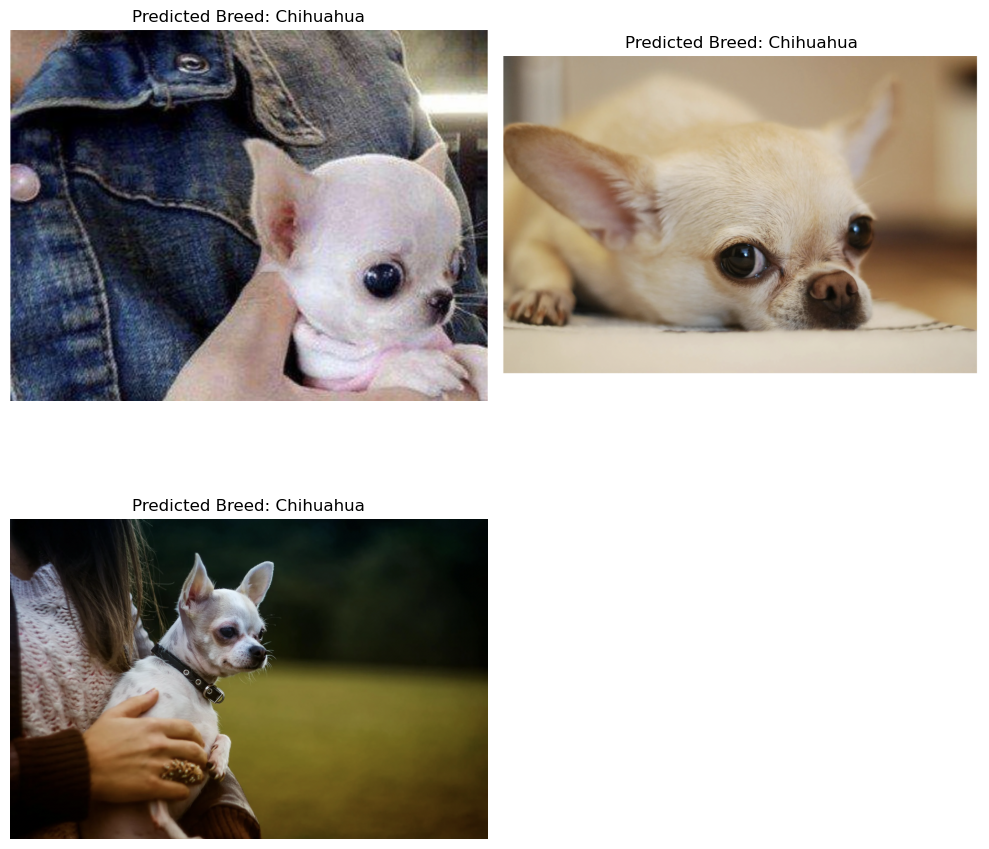

In [35]:

# Define your test image paths as a list
test_image_paths = [
    './test_data/dog1.jpg',
    './test_data/dog2.jpg',
    './test_data/dog3.jpg'
]

# Call the function to predict and visualize the test images
predict_and_visualize(test_image_paths)


In this particular prediction, the largest value is `9.99938965e-01`, which corresponds to the class at index 49. This indicates that the model is almost certain that the input image belongs to the class associated with index 49 in the `dog_breeds` list. The remaining values in the array are very close to zero, signifying that the model assigns extremely low probabilities to the other dog breeds. Essentially, the model is highly confident that the input image corresponds to the dog breed at index 49.

Input shape to VGG16: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Bottleneck features shape: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predictions shape: (1, 133)
Predictions: [[4.0596286e-29 8.5805732e-14 4.5381665e-28 6.4488035e-21 8.8721145e-15
  2.4351108e-11 6.4367756e-24 4.8689526e-18 3.4788429e-28 2.8590913e-10
  7.6671157e-29 4.7419642e-09 3.9560512e-30 2.3805472e-31 6.7372705e-25
  5.5133526e-26 1.9654274e-10 4.4281342e-30 1.6731720e-19 1.0898331e-28
  2.6238990e-18 1.1360047e-20 1.4887143e-16 2.3927251e-19 3.4627800e-22
  3.4628146e-25 2.0239784e-30 5.1846133e-26 1.4426849e-17 1.9659065e-26
  8.3047738e-09 1.5775787e-26 7.0572915e-31 6.6588885e-30 4.6367611e-26
  8.8261003e-16 3.3269842e-16 3.9209501e-25 6.1179955e-25 1.4984033e-19
  1.8887280e-32 3.8966498e-23 4.0820908e-18 4.2292707e-24 1.6535329e-20
  3.8346651e-19 2.1941429e-23 9.2818292e-18 1.3364526e-07 2.0120461e-23
  3.1602458e-20 4.6756883e-14 3.0247181e-22 3.3669721e-16 6.5353044e-22
  3.31634

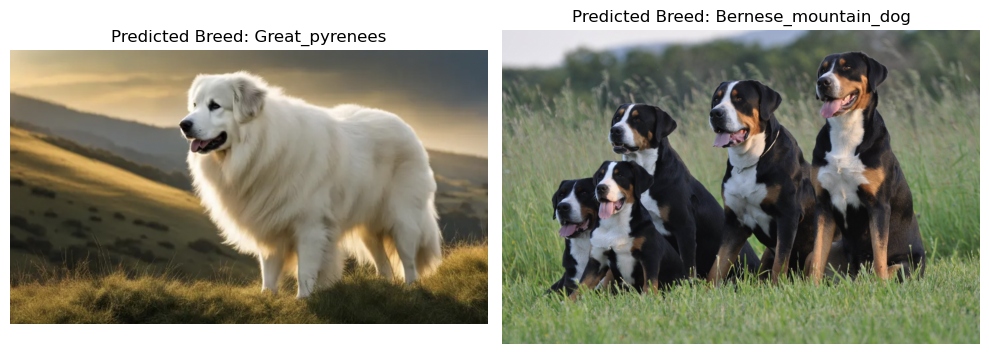

In [30]:

# Define your test image paths as a list
test_image_paths = [
    './test_data/dog4.jpg',
    './test_data/dog5.jpg'
]

# Call the function to predict and visualize the test images
predict_and_visualize(test_image_paths)
